In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib

In [2]:
# import os
# import numpy as np
# import nibabel as nib
# import torchio as tio
# from PIL import Image

# def slice3DImages(input_folder, overlap_ratio):
#     output_folder = input_folder + 'Sliced_exp'

#     # create output folder if it does not exist
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     # iterate over all files in the input folder
#     for filename in os.listdir(input_folder):
#         print(f"Transforming {filename}")
#         output_folder_name = filename.split(".")[0]
#         output_folder_path = os.path.join(output_folder, output_folder_name)
#         os.makedirs(output_folder_path, exist_ok=True)
#         img = nib.load(os.path.join(input_folder, filename))
#         img_data = img.get_fdata()

#         # Add an extra dimension to make it a 4D tensor
#         img_data_4d = np.expand_dims(img_data, axis=0)

#         # Prepare TorchIO subject
#         subject = tio.Subject(image=tio.ScalarImage(tensor=img_data_4d))

#         # Apply TorchIO transform
#         transform = tio.CropOrPad((256, 256, img_data.shape[2]))
#         transformed_subject = transform(subject)
#         img_data = transformed_subject['image'].data.numpy().squeeze()

#         slice_thickness = img_data.shape[2]
#         overlap_pixels = int((1 - overlap_ratio) * slice_thickness)

#         for i in range(0, slice_thickness, overlap_pixels + 1):
#             # Calculate the end index for the current slice
#             end_index = min(i + slice_thickness, img_data.shape[2])
#             slice_2d = img_data[:, :, i:end_index]

#             for j in range(slice_2d.shape[2]):
#                 single_slice = slice_2d[:, :, j]
#                 max_val = np.max(single_slice)
#                 min_val = np.min(single_slice)
                
#                 # Only normalize if there is data
#                 if max_val - min_val > 0:
#                     single_slice_normalized = (single_slice - min_val) / (max_val - min_val)
#                 else:
#                     assert max_val == 0 and min_val == 0
#                     single_slice_normalized = single_slice

#                 # Create PIL Image object and save
#                 img_pil = Image.fromarray(np.uint8(255 * single_slice_normalized))
#                 img_pil.save(os.path.join(output_folder_path, f"png-slice-{str(i).zfill(4)}-{str(j).zfill(2)}.png"))


In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 141]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask


In [4]:
# import numpy as np
# import os
# from torch.utils.data import Dataset
# from PIL import Image
# import torch

# class BrainSegmentationDataset(Dataset):
#     def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None, num_slices=3):
#         self.t1c_dir = t1c_dir
#         self.t2f_dir = t2f_dir
#         self.seg_dir = seg_dir
#         self.transforms = transforms
#         self.num_slices = num_slices

#         # Create a list of all seg images (patient + slice)
#         self.seg_files = sorted([os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
#                           for file in files if os.path.getsize(os.path.join(root, file)) > 141])

#     def __len__(self):
#         return len(self.seg_files)

#     def __getitem__(self, idx):
#         seg_img_path = self.seg_files[idx]
#         mask = Image.open(seg_img_path).convert('L')
#         mask = np.array(mask, dtype=np.int64)
        
#         background_mask = (mask == 0).astype(np.float32)
#         class1_mask = (mask == 85).astype(np.float32)
#         class2_mask = (mask == 170).astype(np.float32)
#         class3_mask = (mask == 255).astype(np.float32)
        
#         mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
#         mask = np.argmax(mask, axis=2)

#         # Load neighboring slices
#         t1c_tensors = []
#         t2f_tensors = []
#         for i in range(-(self.num_slices // 2), (self.num_slices // 2) + 1):
#             curr_idx = idx + i
#             if curr_idx < 0 or curr_idx >= len(self.seg_files):
#                 # Skip the current iteration if there are no valid neighboring slices
#                 continue

#             t1c_img_path = self.seg_files[curr_idx].replace('seg', 't1c')
#             t2f_img_path = self.seg_files[curr_idx].replace('seg', 't2f')

#             if os.path.exists(t1c_img_path) and os.path.exists(t2f_img_path):
#                 t1c_img = Image.open(t1c_img_path).convert('L')
#                 t1c_tensor = torch.from_numpy(np.array(t1c_img, dtype=np.float32)[None, ...]) / 255.0

#                 t2f_img = Image.open(t2f_img_path)
#                 t2f_tensor = torch.from_numpy(np.array(t2f_img, dtype=np.float32)[None, ...]) / 255.0

#                 t1c_tensors.append(t1c_tensor)
#                 t2f_tensors.append(t2f_tensor)

#         # Check if there are valid neighboring slices available
#         if len(t1c_tensors) == 0 or len(t2f_tensors) == 0:
#             # Handle edge cases by returning None for inputs and mask
#             return None, None

#         # Stack t1c and t2f tensors along the channel dimension
#         t1c_stacked = torch.cat(t1c_tensors, dim=0)
#         t2f_stacked = torch.cat(t2f_tensors, dim=0)
#         inputs = torch.cat((t1c_stacked, t2f_stacked), dim=0)

#         return inputs, mask


In [5]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="BraTS_2023_train/t1cSliced_exp", t2f_dir="BraTS_2023_train/t2fSliced_exp", seg_dir="BraTS_2023_train/segSliced_exp", transforms=data_transforms)


In [6]:
def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # remove None elements from batch
    return torch.utils.data.dataloader.default_collate(batch)  # use PyTorch's default collate function on the filtered batch


In [7]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)


In [8]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


98052
4086
Data shape: torch.Size([24, 2, 256, 256])
Labels shape: torch.Size([24, 256, 256])
Data shape: torch.Size([24, 2, 256, 256])
Labels shape: torch.Size([24, 256, 256])


In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = self.up6(c5)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)
        up7 = self.up7(c6)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)
        up8 = self.up8(c7)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)
        up9 = self.up9(c8)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [10]:
def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()


In [11]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)

In [12]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_model_overlap.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_model_overlap.pth")

    
    return model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


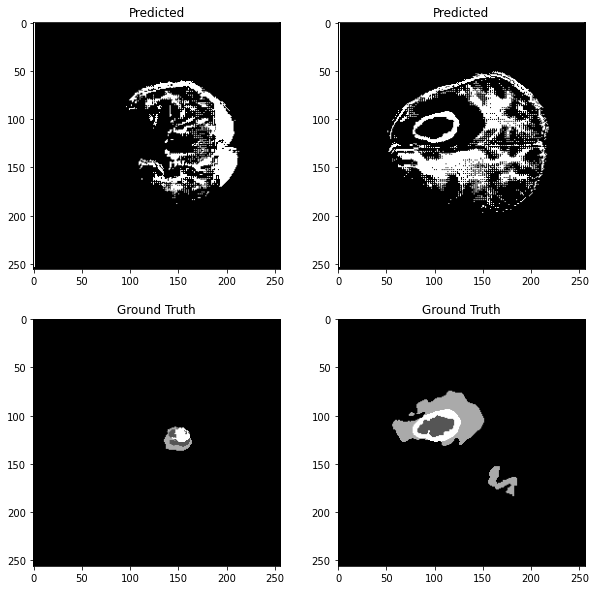

100%|██████████| 4086/4086 [50:33<00:00,  1.35it/s]



Average Training Loss: 0.04084055792386231

Average Training DSC: [0.99641387 0.65716918 0.51654882 0.47790699]
Average Training ASSD: [ 0.99567221 85.51221673 96.39847293 76.31605748]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


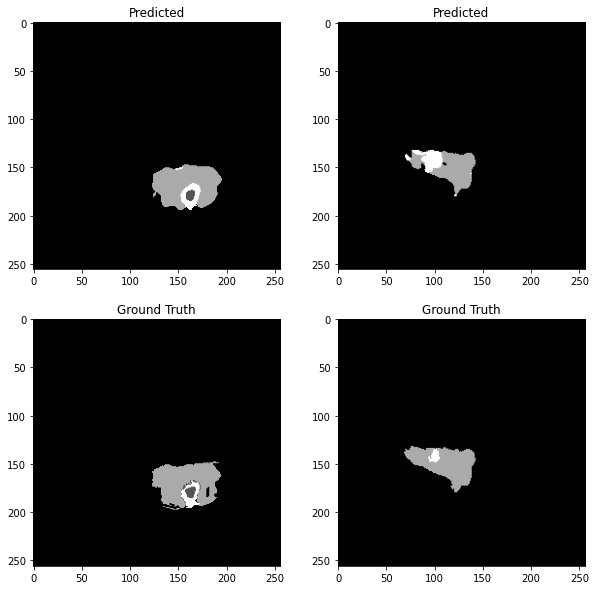

100%|██████████| 1022/1022 [08:35<00:00,  1.98it/s]


Average Validation Loss: 0.020757751388077984

Average Validation DSC: [0.99755651 0.77491286 0.73004319 0.67244463]
Average Validation ASSD: [ 0.46384601 36.28563964 36.66756844 19.53294343]
Epoch 2/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


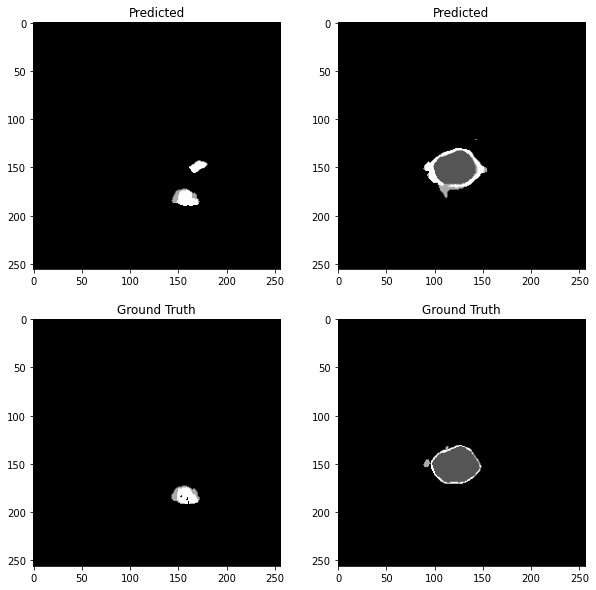

100%|██████████| 4086/4086 [50:39<00:00,  1.34it/s]



Average Training Loss: 0.016345297125210538

Average Training DSC: [0.99809403 0.7914953  0.77216636 0.70335969]
Average Training ASSD: [ 0.37439275 34.96498771 35.02353715 21.55893   ]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


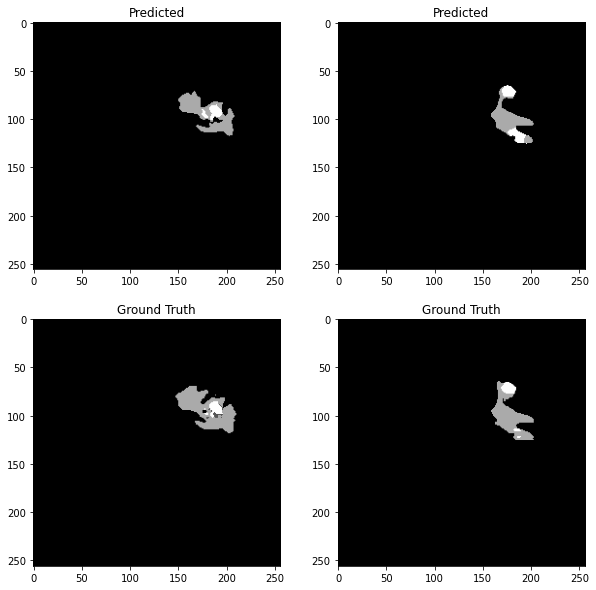

100%|██████████| 1022/1022 [08:10<00:00,  2.08it/s]


Average Validation Loss: 0.014933532277038303

Average Validation DSC: [0.99816816 0.81912865 0.77534672 0.71855881]
Average Validation ASSD: [ 0.33177798 28.96041226 31.41589676 21.69614452]
Epoch 3/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


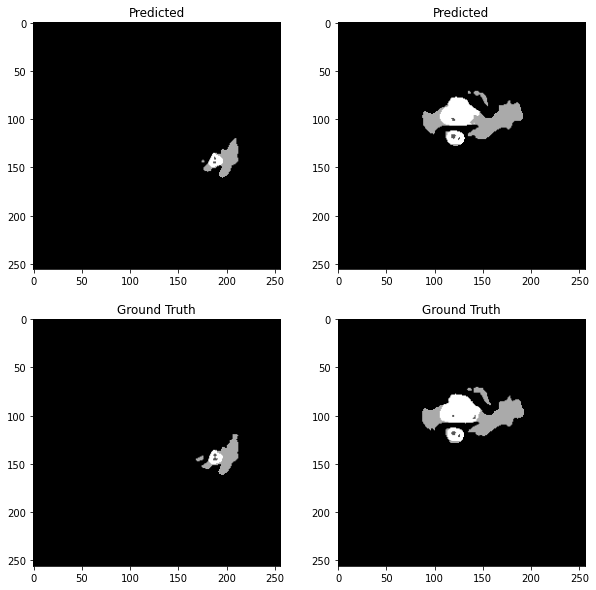

100%|██████████| 4086/4086 [51:09<00:00,  1.33it/s]



Average Training Loss: 0.011984291430257308

Average Training DSC: [0.99852522 0.82818499 0.82797033 0.74872854]
Average Training ASSD: [ 0.27346473 28.0046624  24.06105816 18.48134922]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


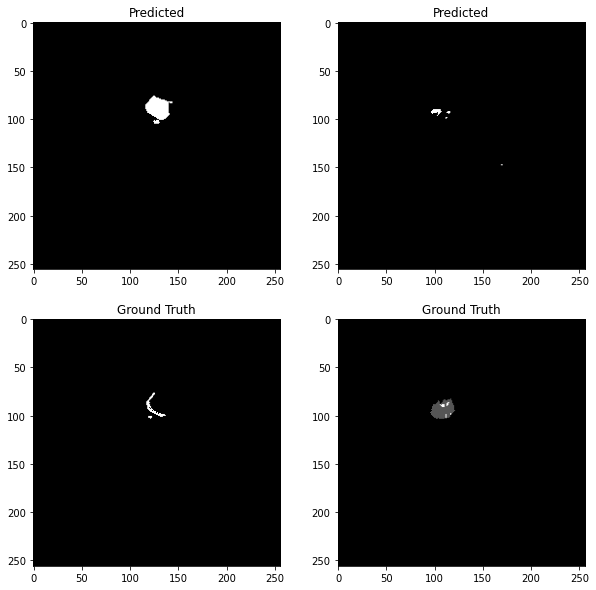

100%|██████████| 1022/1022 [08:18<00:00,  2.05it/s]


Average Validation Loss: 0.011177199794737707

Average Validation DSC: [0.99858475 0.84231869 0.85099145 0.74935448]
Average Validation ASSD: [ 0.2731811  25.23414034 17.72181335 23.22418077]
Epoch 4/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


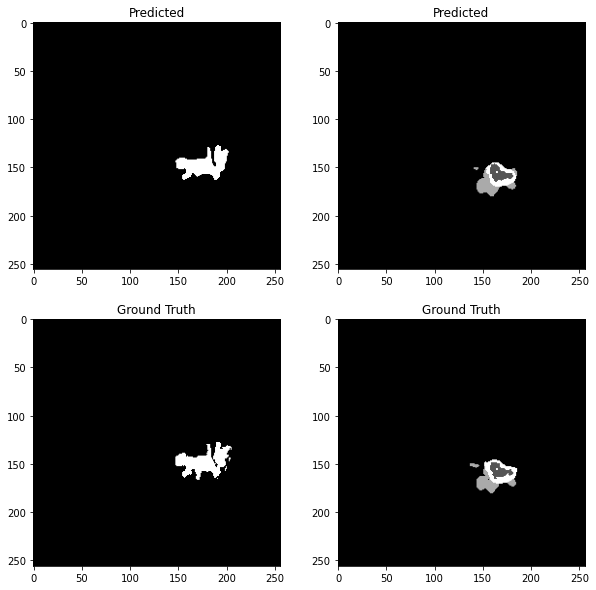

100%|██████████| 4086/4086 [50:49<00:00,  1.34it/s]



Average Training Loss: 0.009484754501268946

Average Training DSC: [0.99879348 0.849447   0.86374121 0.78232601]
Average Training ASSD: [ 0.21048826 24.14389371 17.09729685 16.69968319]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


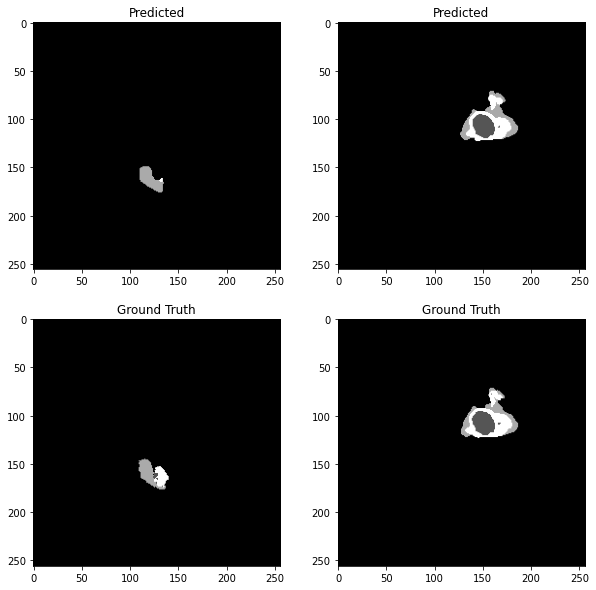

100%|██████████| 1022/1022 [08:13<00:00,  2.07it/s]


Average Validation Loss: 0.009320499768677494

Average Validation DSC: [0.99883934 0.8628954  0.87362213 0.79511607]
Average Validation ASSD: [ 0.1890454  22.16391166 13.98972791 12.91985032]
Epoch 5/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


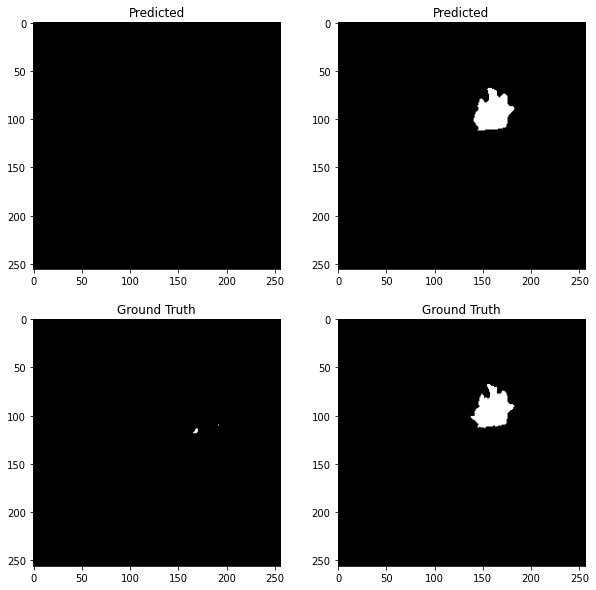

100%|██████████| 4086/4086 [51:53<00:00,  1.31it/s]



Average Training Loss: 0.008259419829785692

Average Training DSC: [0.99892865 0.86219702 0.8816212  0.80276035]
Average Training ASSD: [ 0.17639201 21.72926862 13.96454786 15.20555743]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


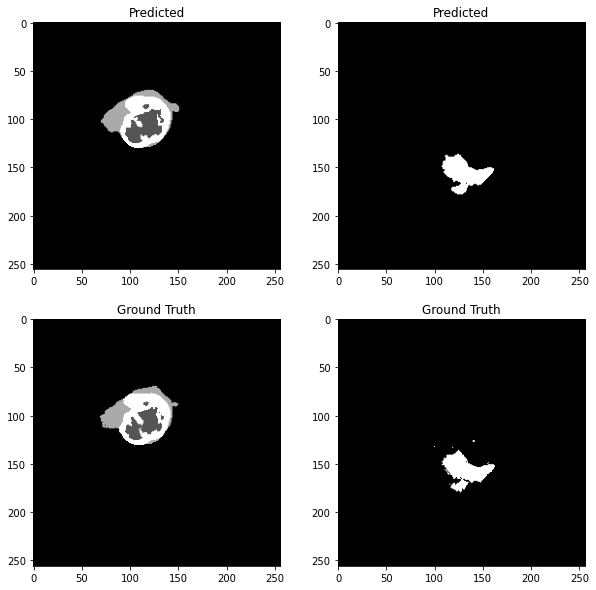

100%|██████████| 1022/1022 [08:39<00:00,  1.97it/s]


Average Validation Loss: 0.008311455844265432

Average Validation DSC: [0.99897483 0.87003636 0.88846386 0.80828718]
Average Validation ASSD: [ 0.16601695 20.1460215  12.58713914 11.98368555]
Epoch 6/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


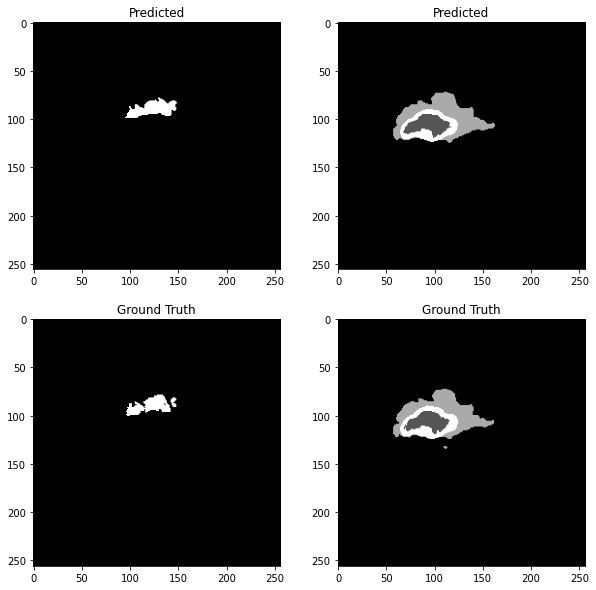

100%|██████████| 4086/4086 [50:56<00:00,  1.34it/s]



Average Training Loss: 0.0071863576196470515

Average Training DSC: [0.99904836 0.87273308 0.8973314  0.82075564]
Average Training ASSD: [ 0.14715199 19.50091703 11.122029   14.19358063]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


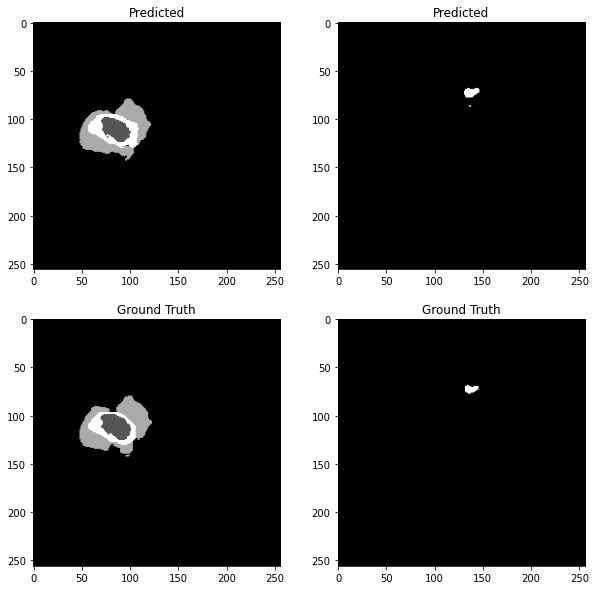

100%|██████████| 1022/1022 [08:28<00:00,  2.01it/s]


Average Validation Loss: 0.007802331133712805

Average Validation DSC: [0.99902804 0.87855461 0.8927445  0.80877014]
Average Validation ASSD: [ 0.16262195 18.36350865 11.61255898 15.16503327]
Epoch 7/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


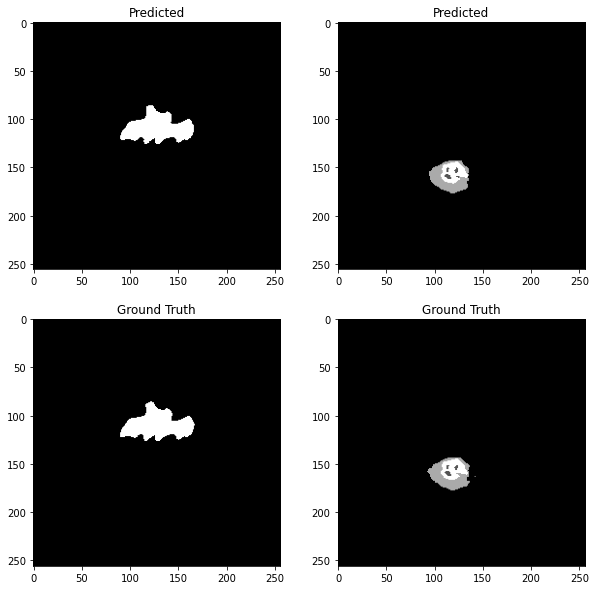

100%|██████████| 4086/4086 [52:33<00:00,  1.30it/s]



Average Training Loss: 0.006541712018690832

Average Training DSC: [0.99912214 0.88089507 0.90697342 0.83282911]
Average Training ASSD: [ 0.13042726 17.85999337  9.45416671 13.08530486]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


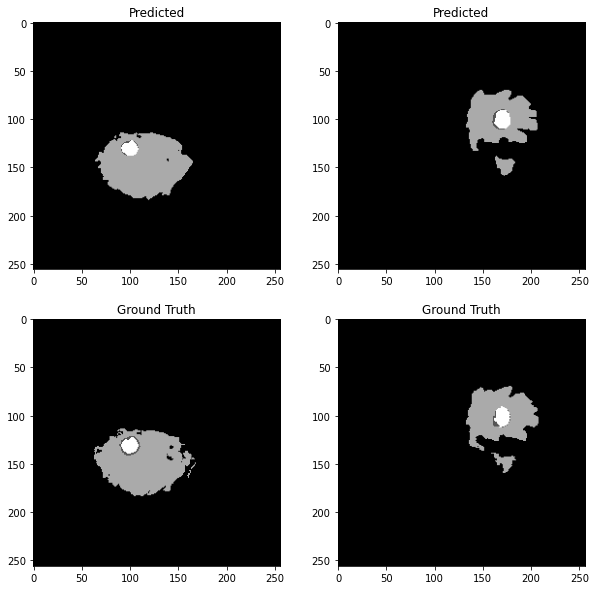

100%|██████████| 1022/1022 [08:39<00:00,  1.97it/s]


Average Validation Loss: 0.00754757036469556

Average Validation DSC: [0.99907505 0.87391165 0.84328483 0.80656047]
Average Validation ASSD: [ 0.14121546 19.88601258 31.79136772 17.10627705]
Epoch 8/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


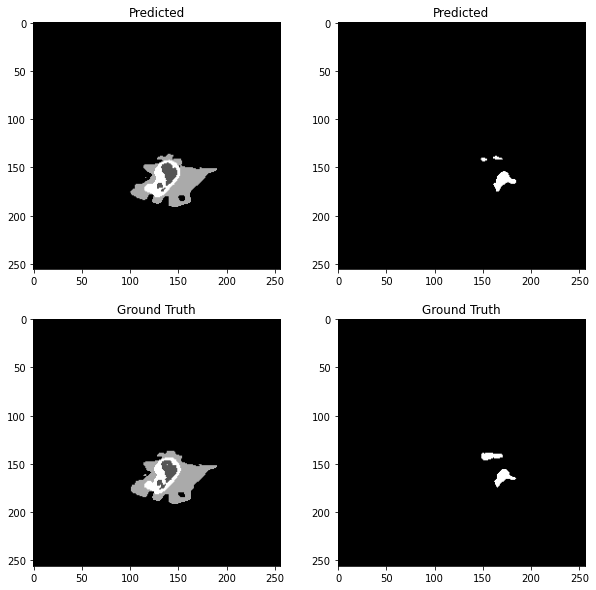

100%|██████████| 4086/4086 [52:30<00:00,  1.30it/s]



Average Training Loss: 0.005991263850831404

Average Training DSC: [0.99918638 0.88843687 0.91467521 0.84363649]
Average Training ASSD: [ 0.11748877 16.27140012  8.3071223  12.48170145]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


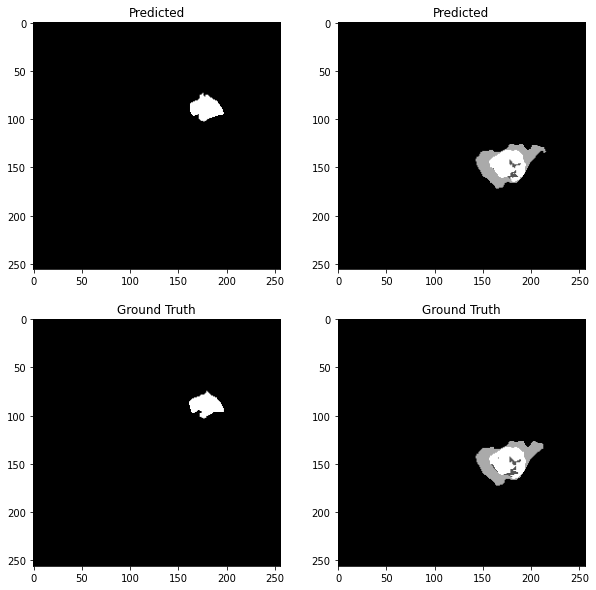

100%|██████████| 1022/1022 [08:40<00:00,  1.96it/s]


Average Validation Loss: 0.006527204425101498

Average Validation DSC: [0.99918431 0.88821154 0.91055479 0.8368679 ]
Average Validation ASSD: [ 0.12116674 16.46093139  9.7315044  12.79048428]
Epoch 9/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


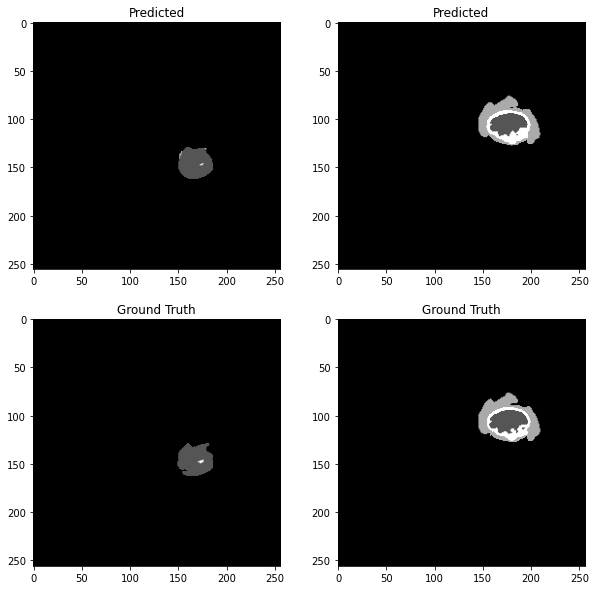

100%|██████████| 4086/4086 [52:47<00:00,  1.29it/s]



Average Training Loss: 0.005624460632517584

Average Training DSC: [0.99922881 0.89313977 0.9201458  0.85157204]
Average Training ASSD: [ 0.10793379 15.24401396  7.53048438 11.72349417]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


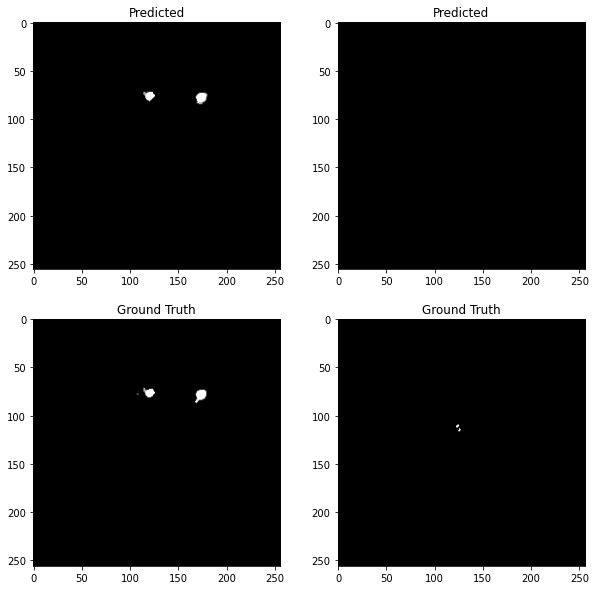

100%|██████████| 1022/1022 [08:38<00:00,  1.97it/s]


Average Validation Loss: 0.006419216669501769

Average Validation DSC: [0.99919159 0.89188213 0.91472754 0.83617567]
Average Validation ASSD: [ 0.11777222 15.6062957   9.15243467 13.08516557]
Epoch 10/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


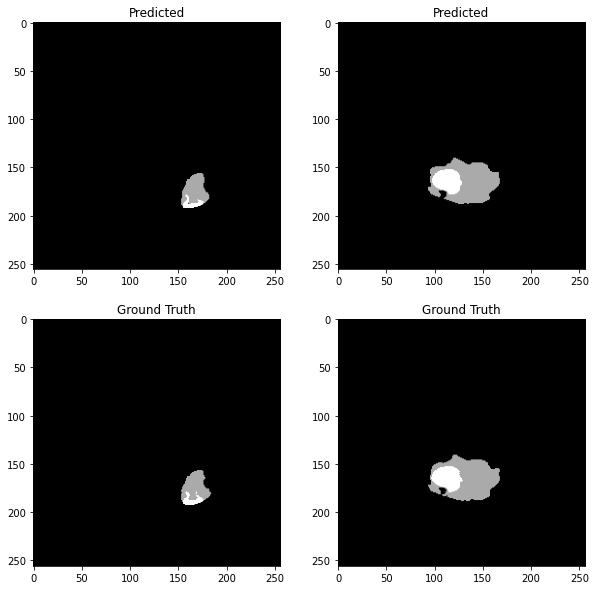

100%|██████████| 4086/4086 [52:40<00:00,  1.29it/s]



Average Training Loss: 0.005240297588536619

Average Training DSC: [0.99927298 0.89883357 0.92712325 0.85944327]
Average Training ASSD: [ 0.10000393 13.97246773  6.15589146 11.25437565]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


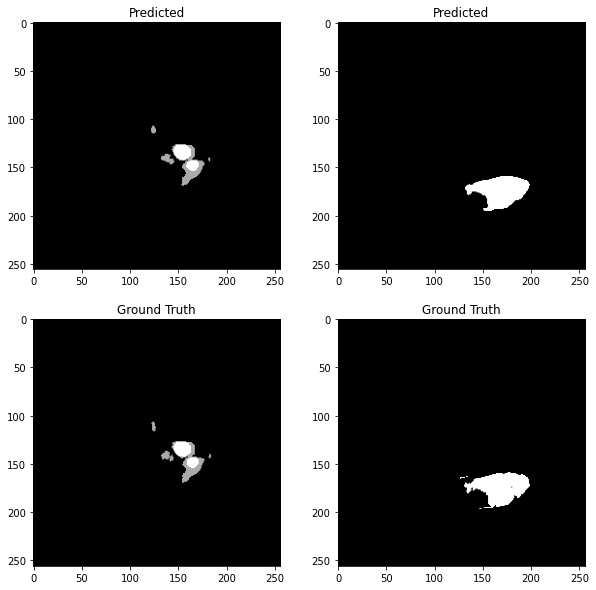

100%|██████████| 1022/1022 [08:43<00:00,  1.95it/s]


Average Validation Loss: 0.005883895535771088

Average Validation DSC: [0.99924482 0.89833093 0.91527867 0.84934926]
Average Validation ASSD: [ 0.1042821  15.08024835  9.9258489  10.18022741]
Epoch 11/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


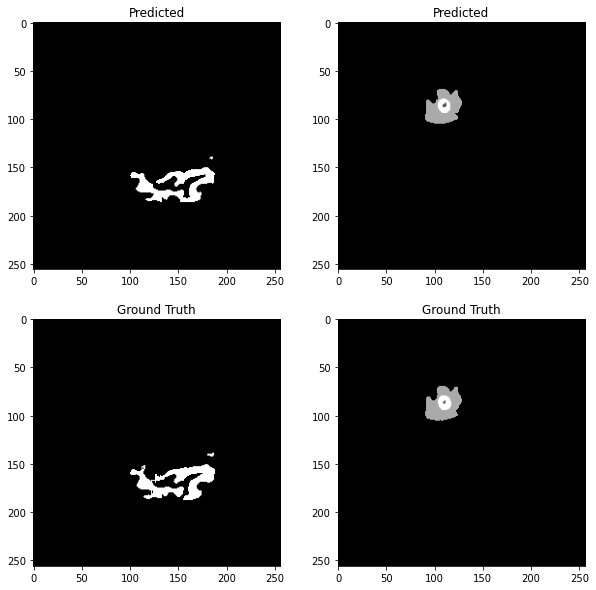

100%|██████████| 4086/4086 [52:09<00:00,  1.31it/s]



Average Training Loss: 0.004969666443598319

Average Training DSC: [0.99930865 0.90307344 0.93046481 0.86530002]
Average Training ASSD: [ 0.09391914 13.16176923  5.7607112  10.74987014]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


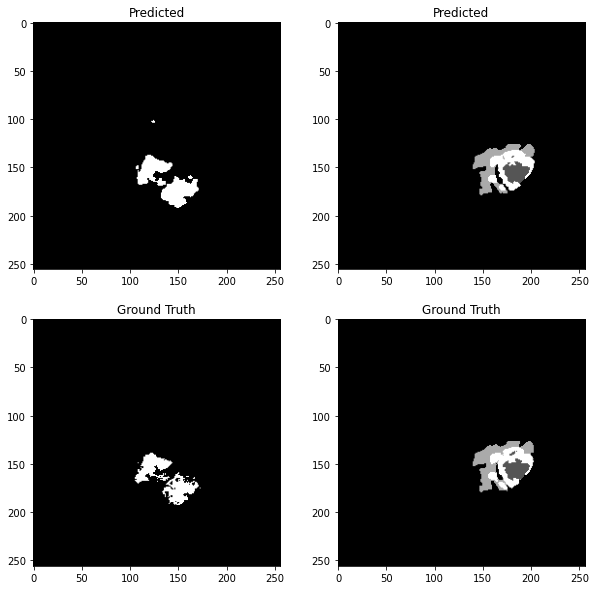

100%|██████████| 1022/1022 [08:33<00:00,  1.99it/s]


Average Validation Loss: 0.0057422598184190266

Average Validation DSC: [0.99927159 0.90301974 0.91712988 0.85073545]
Average Validation ASSD: [ 0.10568967 13.74170638  9.77126397 11.59564634]
Epoch 12/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


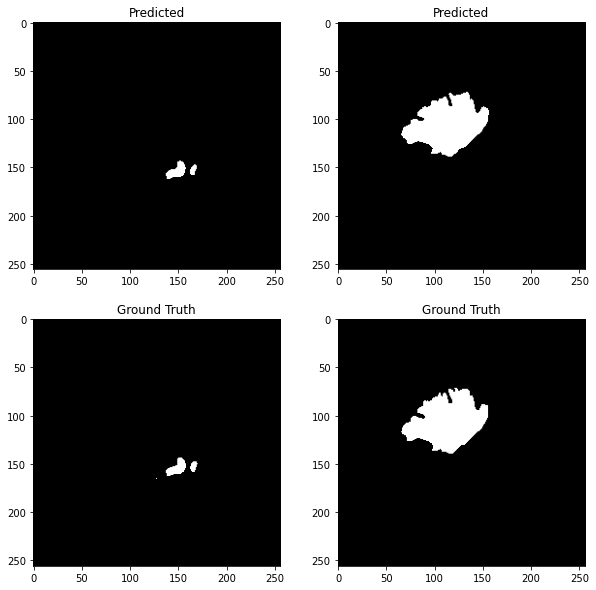

100%|██████████| 4086/4086 [52:39<00:00,  1.29it/s]



Average Training Loss: 0.004712697241716981

Average Training DSC: [0.99934169 0.90609163 0.93403467 0.87109317]
Average Training ASSD: [ 0.08796023 12.60255351  5.3232489   9.91448851]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


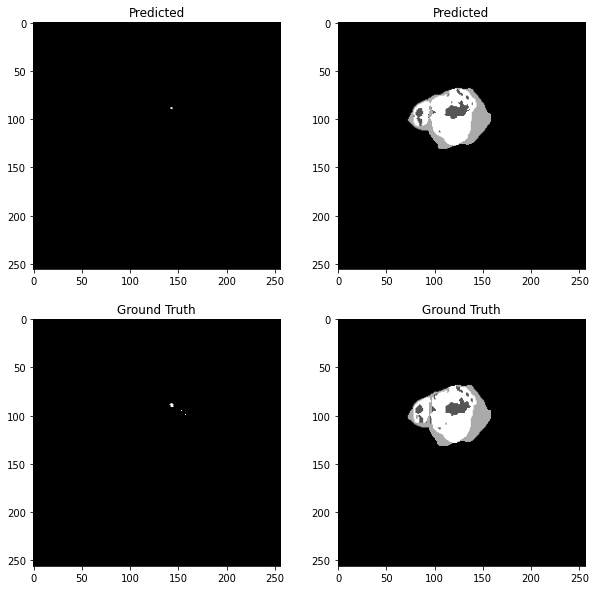

100%|██████████| 1022/1022 [08:39<00:00,  1.97it/s]


Average Validation Loss: 0.005955161691739892

Average Validation DSC: [0.99924332 0.89920898 0.9135953  0.85208473]
Average Validation ASSD: [ 0.10628243 14.6921837  10.2835919   9.24902278]
Epoch 13/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


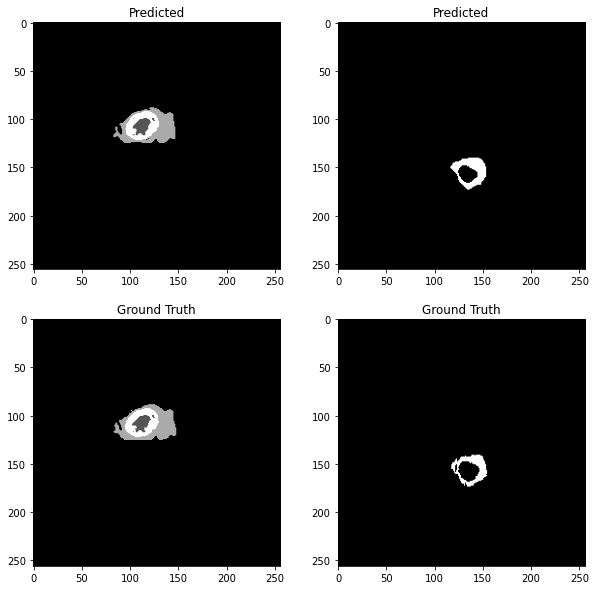

100%|██████████| 4086/4086 [52:12<00:00,  1.30it/s]



Average Training Loss: 0.0045250341116359095

Average Training DSC: [0.9993643  0.9093422  0.93797115 0.87638861]
Average Training ASSD: [ 0.08357927 11.76121285  4.66097356  9.72868419]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


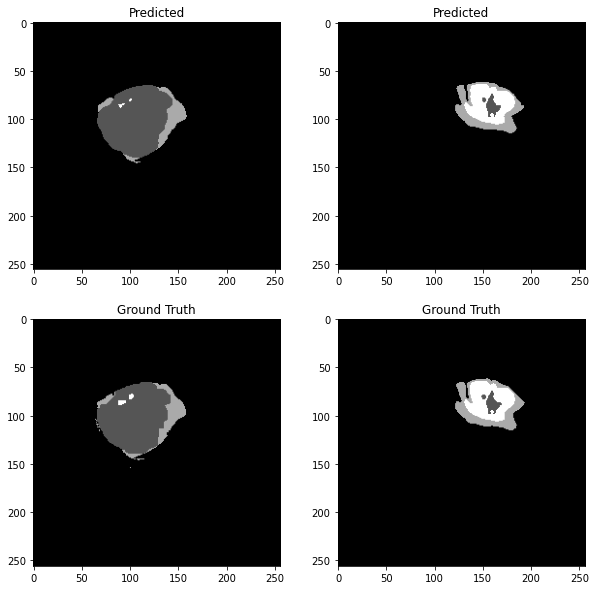

100%|██████████| 1022/1022 [08:40<00:00,  1.96it/s]


Average Validation Loss: 0.0054789795672408

Average Validation DSC: [0.99931744 0.90545634 0.92481111 0.86120432]
Average Validation ASSD: [ 0.09483234 13.56451662  7.91661007  9.43586394]
Epoch 14/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


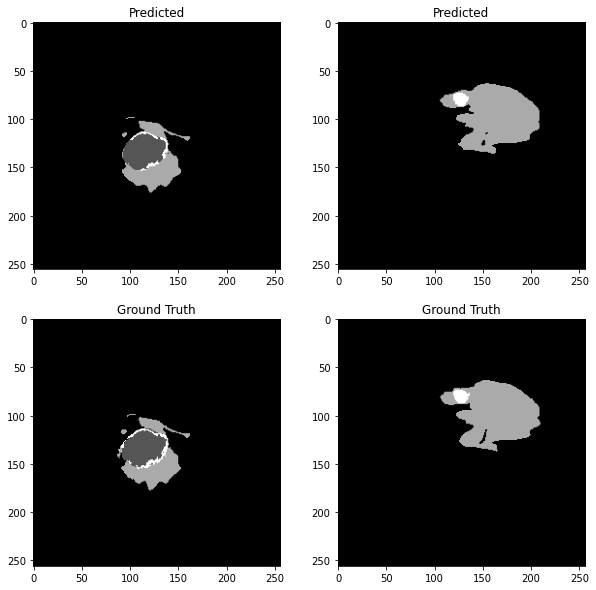

100%|██████████| 4086/4086 [52:47<00:00,  1.29it/s]



Average Training Loss: 0.0042557774744818476

Average Training DSC: [0.99939838 0.91273148 0.94118665 0.88158314]
Average Training ASSD: [ 0.07835245 11.25203817  4.34377217  9.22783259]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


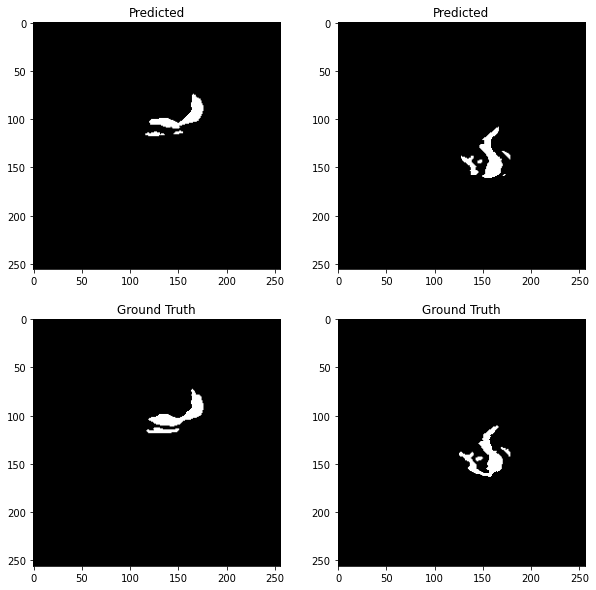

100%|██████████| 1022/1022 [08:42<00:00,  1.96it/s]


Average Validation Loss: 0.005257463420070562

Average Validation DSC: [0.99933779 0.90904021 0.92683961 0.86363574]
Average Validation ASSD: [ 0.09116685 12.53622304  8.01486796  9.7296686 ]
Epoch 15/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


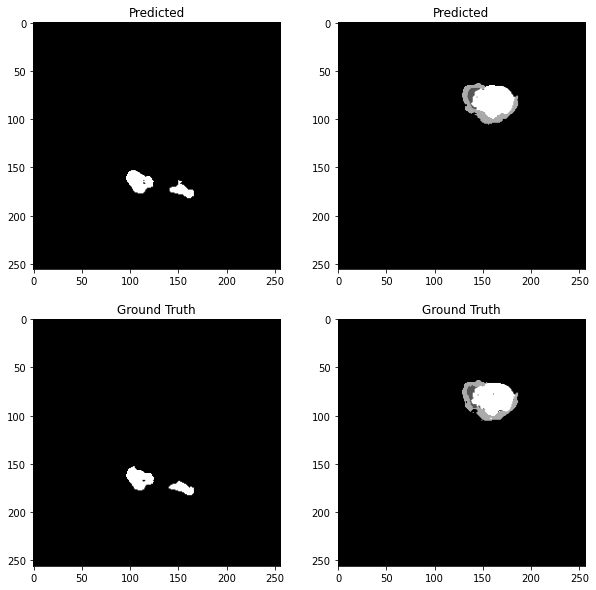

100%|██████████| 4086/4086 [52:44<00:00,  1.29it/s]



Average Training Loss: 0.004078388942234178

Average Training DSC: [0.99942262 0.91558229 0.94396578 0.88590257]
Average Training ASSD: [ 0.07441769 10.67588487  3.84566926  9.04047056]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


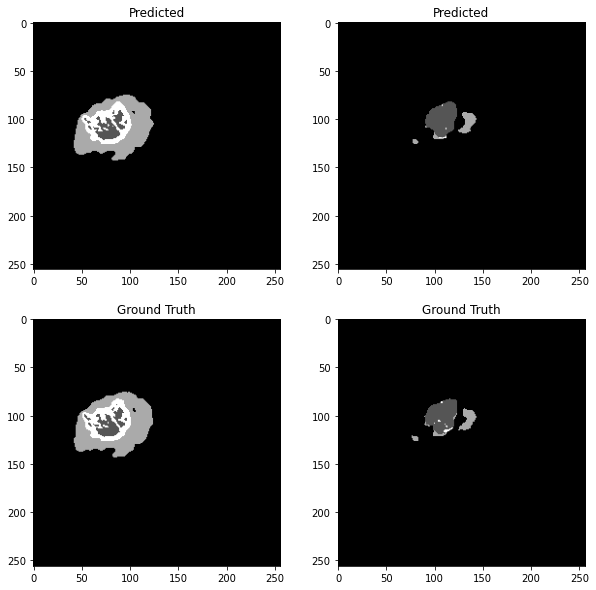

100%|██████████| 1022/1022 [08:40<00:00,  1.96it/s]


Average Validation Loss: 0.005283015989516215

Average Validation DSC: [0.99935165 0.90720418 0.92878003 0.86905803]
Average Validation ASSD: [ 0.08812392 12.79603637  7.62919267  9.34201384]
Epoch 16/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


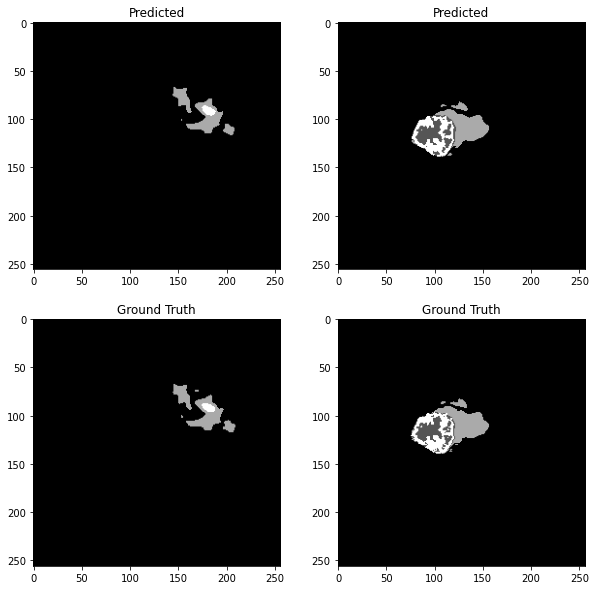

100%|██████████| 4086/4086 [53:02<00:00,  1.28it/s]



Average Training Loss: 0.0039304081683684865

Average Training DSC: [0.99944149 0.91768339 0.94571873 0.8889794 ]
Average Training ASSD: [ 0.07167271 10.26159357  3.66608116  8.78326277]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


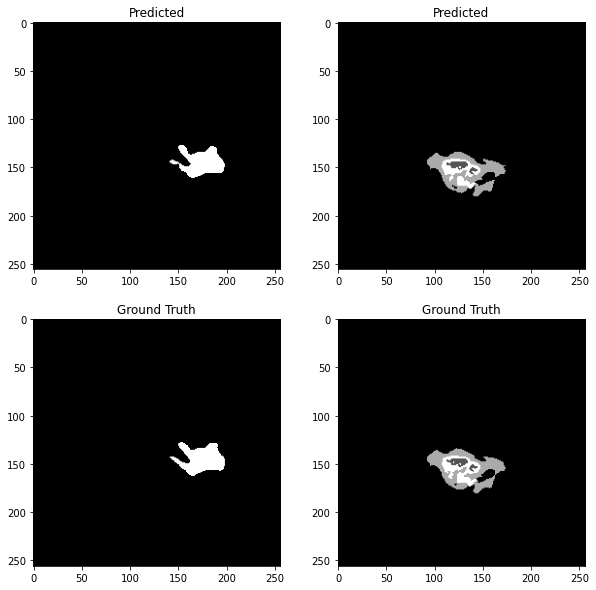

100%|██████████| 1022/1022 [08:44<00:00,  1.95it/s]


Average Validation Loss: 0.005153641440502847

Average Validation DSC: [0.99937521 0.91414336 0.9316901  0.87123394]
Average Validation ASSD: [ 0.08544705 11.3926914   6.94338666  9.12003733]
Epoch 17/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


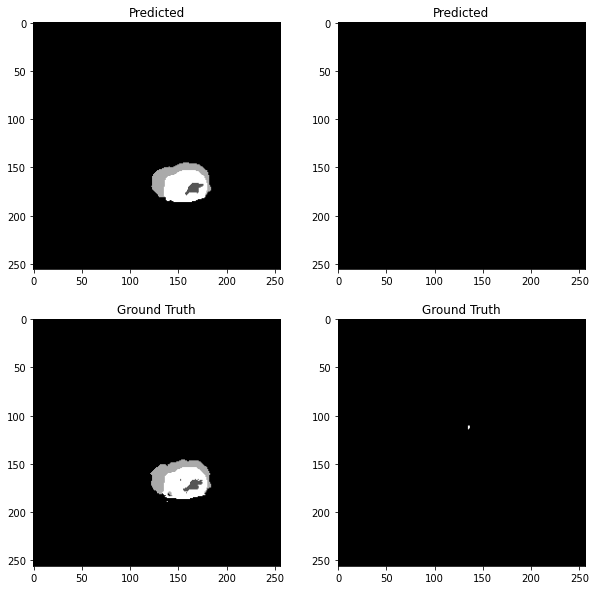

100%|██████████| 4086/4086 [53:00<00:00,  1.28it/s]



Average Training Loss: 0.0037687403998714684

Average Training DSC: [0.99946609 0.92024409 0.94841987 0.89326779]
Average Training ASSD: [0.06794402 9.84631797 3.39963998 8.41547447]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


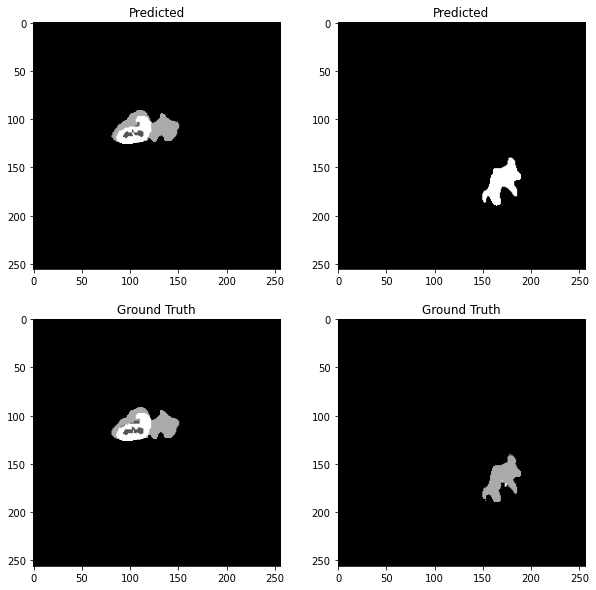

100%|██████████| 1022/1022 [08:44<00:00,  1.95it/s]


Average Validation Loss: 0.004940340508672239

Average Validation DSC: [0.99940221 0.91664798 0.93368744 0.87521494]
Average Validation ASSD: [ 0.08118675 10.88440963  6.96669109  9.15695182]
Epoch 18/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


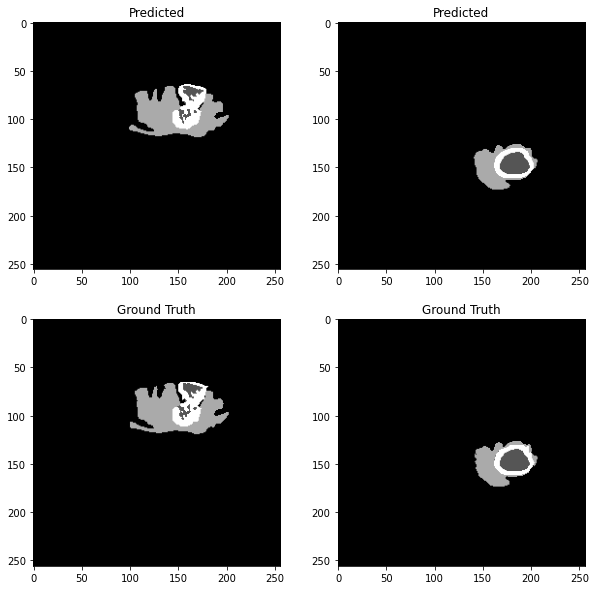

100%|██████████| 4086/4086 [53:11<00:00,  1.28it/s]



Average Training Loss: 0.0036253542084305223

Average Training DSC: [0.99948452 0.92327127 0.95092576 0.89635576]
Average Training ASSD: [0.06527063 9.28403235 2.96415537 8.18006875]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


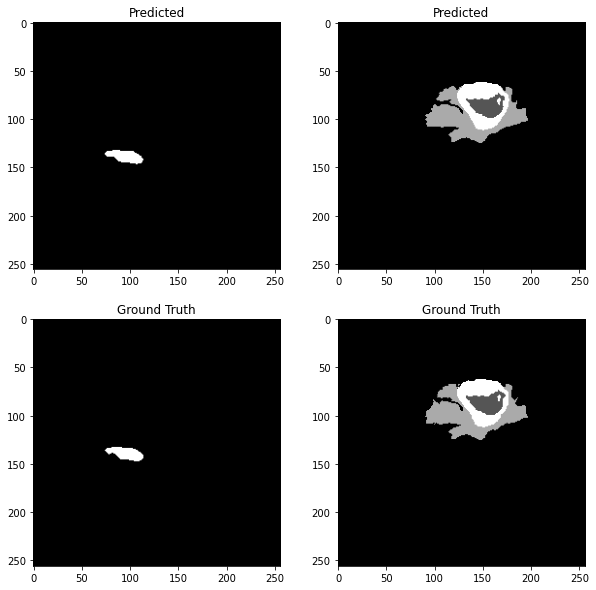

100%|██████████| 1022/1022 [08:43<00:00,  1.95it/s]


Average Validation Loss: 0.005132560083759245

Average Validation DSC: [0.99938083 0.90878124 0.93227106 0.86897697]
Average Validation ASSD: [ 0.08675084 12.69428473  6.77916581  8.87833025]
Epoch 19/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


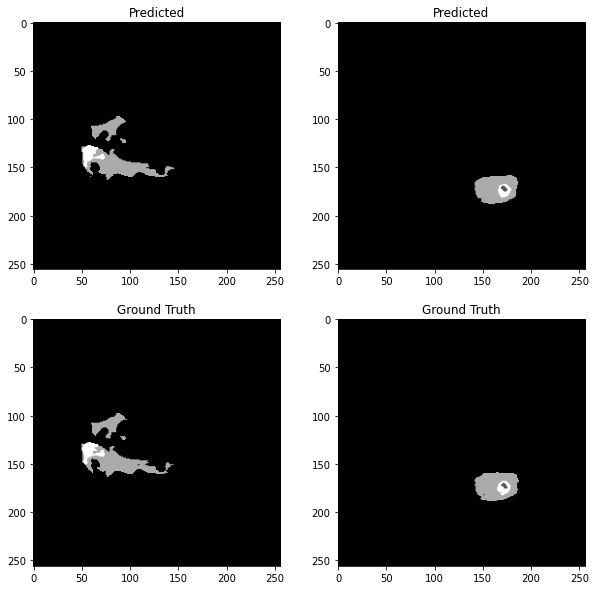

100%|██████████| 4086/4086 [53:00<00:00,  1.28it/s]



Average Training Loss: 0.0034698666985615327

Average Training DSC: [0.99950477 0.92480787 0.95282543 0.89991578]
Average Training ASSD: [0.06194119 8.99911776 2.79730851 7.83597599]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


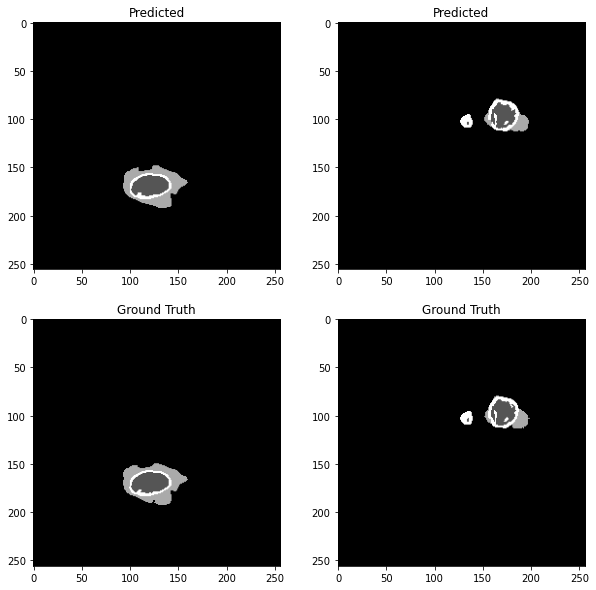

100%|██████████| 1022/1022 [08:37<00:00,  1.98it/s]


Average Validation Loss: 0.0049409390581633215

Average Validation DSC: [0.99940322 0.91372487 0.93447198 0.87601139]
Average Validation ASSD: [ 0.0806704  11.29412257  6.8955237   9.56844366]
Epoch 20/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


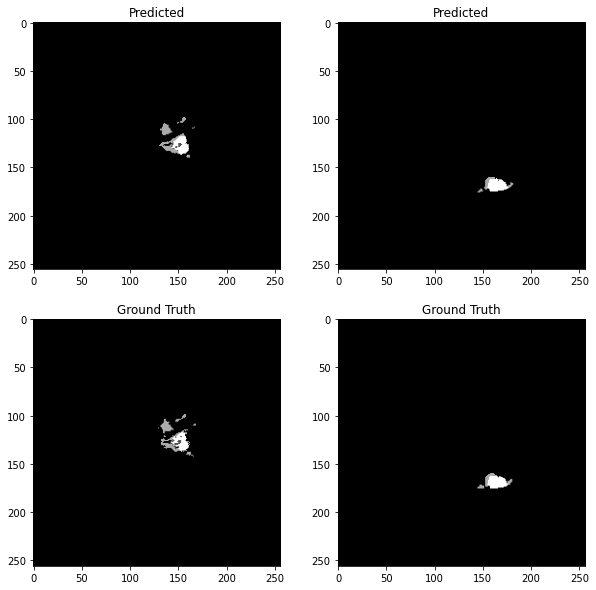

100%|██████████| 4086/4086 [52:40<00:00,  1.29it/s]



Average Training Loss: 0.0033941100986240903

Average Training DSC: [0.99951528 0.92593826 0.95382074 0.90208836]
Average Training ASSD: [0.06098964 8.89037079 2.60843376 7.72911601]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


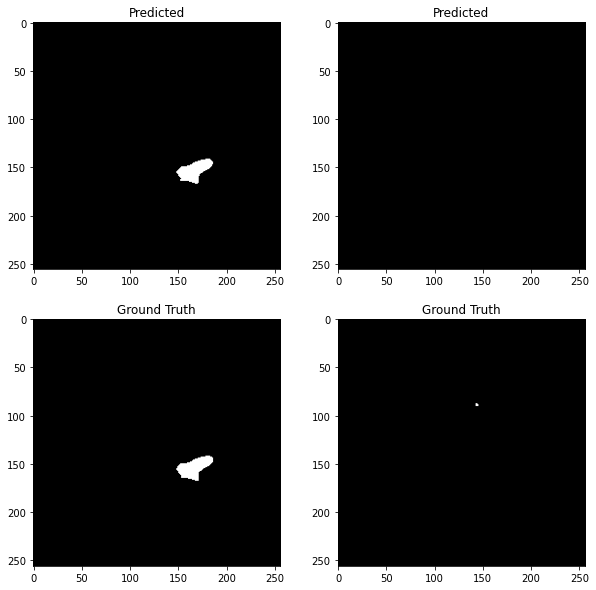

100%|██████████| 1022/1022 [08:40<00:00,  1.96it/s]


Average Validation Loss: 0.005120858890660574

Average Validation DSC: [0.99937354 0.91161024 0.92234908 0.87072665]
Average Validation ASSD: [ 0.0874597  12.01893204 10.38592222  9.87446778]
Epoch 21/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


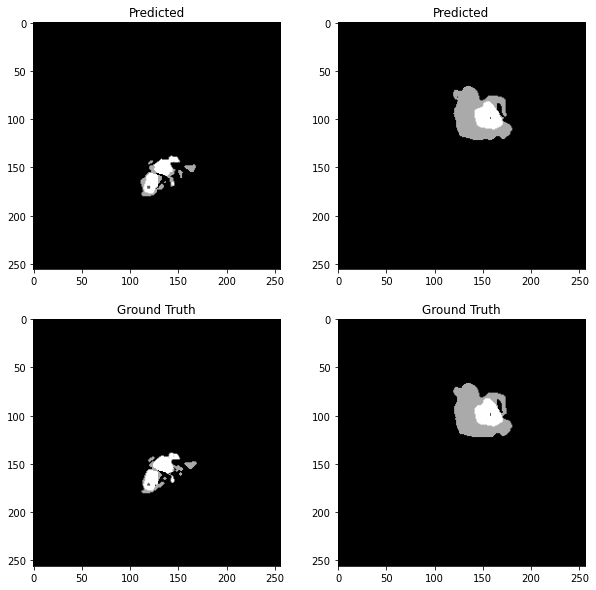

100%|██████████| 4086/4086 [52:55<00:00,  1.29it/s]



Average Training Loss: 0.0031613131057506593

Average Training DSC: [0.99954641 0.92908922 0.95731258 0.90697785]
Average Training ASSD: [0.05616325 8.23752136 2.24416391 7.4520649 ]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


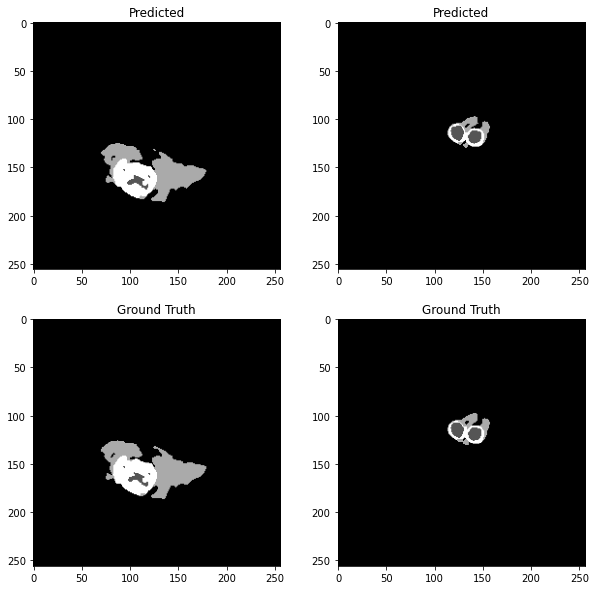

100%|██████████| 1022/1022 [08:35<00:00,  1.98it/s]


Average Validation Loss: 0.004683112540968499

Average Validation DSC: [0.99944295 0.91682928 0.93754446 0.88434907]
Average Validation ASSD: [ 0.07250032 11.11903323  6.70721424  7.37213757]
Epoch 22/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


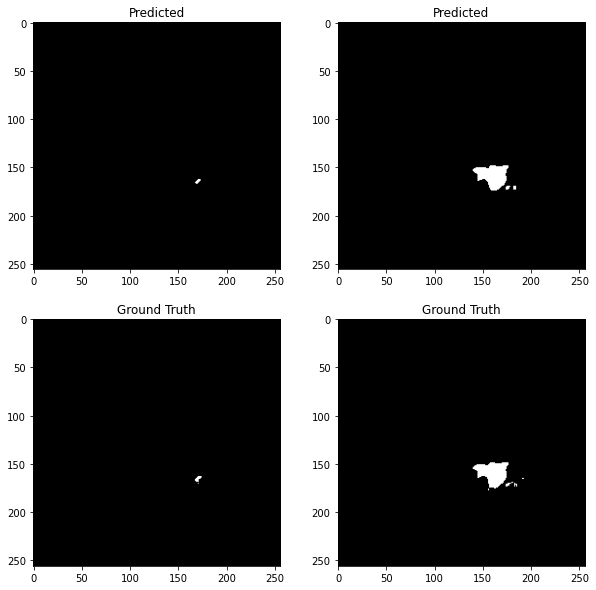

100%|██████████| 4086/4086 [52:47<00:00,  1.29it/s]



Average Training Loss: 0.0030961857171960786

Average Training DSC: [0.99955724 0.93027707 0.9586183  0.90933783]
Average Training ASSD: [0.05436567 7.96988098 2.08525929 6.93465898]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


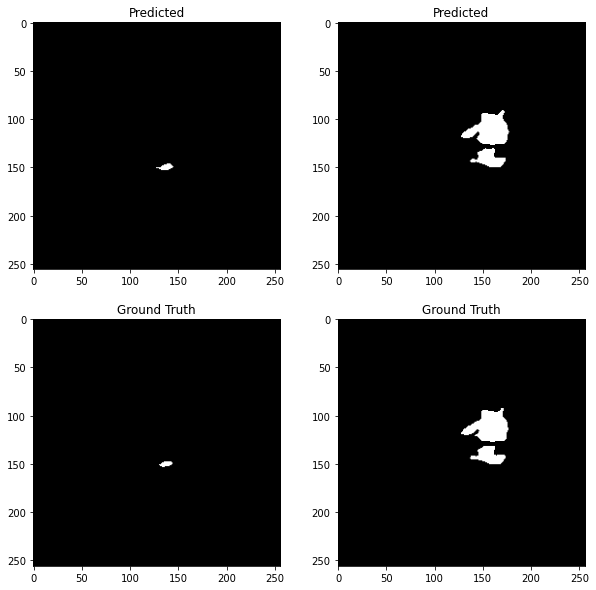

100%|██████████| 1022/1022 [08:45<00:00,  1.94it/s]


Average Validation Loss: 0.004677305678876186

Average Validation DSC: [0.99946396 0.92025769 0.93850817 0.88485761]
Average Validation ASSD: [ 0.07241264 10.2497825   6.51893488  8.01767713]
Epoch 23/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


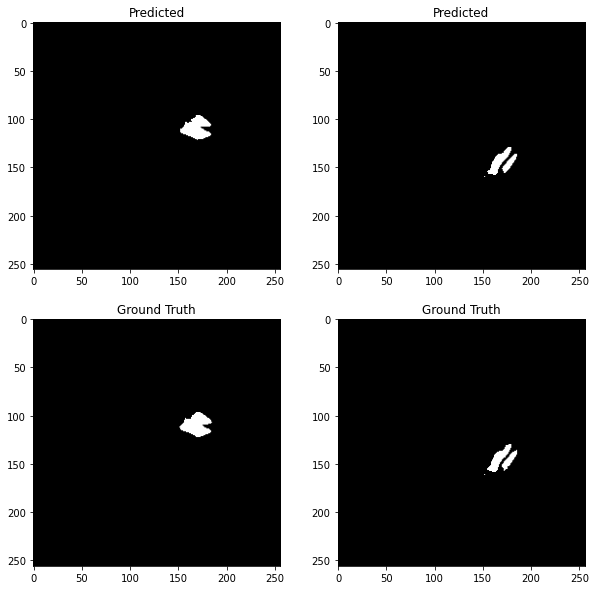

100%|██████████| 4086/4086 [52:52<00:00,  1.29it/s]



Average Training Loss: 0.00310482229540905

Average Training DSC: [0.9995599  0.9308257  0.95831614 0.90956132]
Average Training ASSD: [0.05412402 7.92179549 2.24805884 7.06254569]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


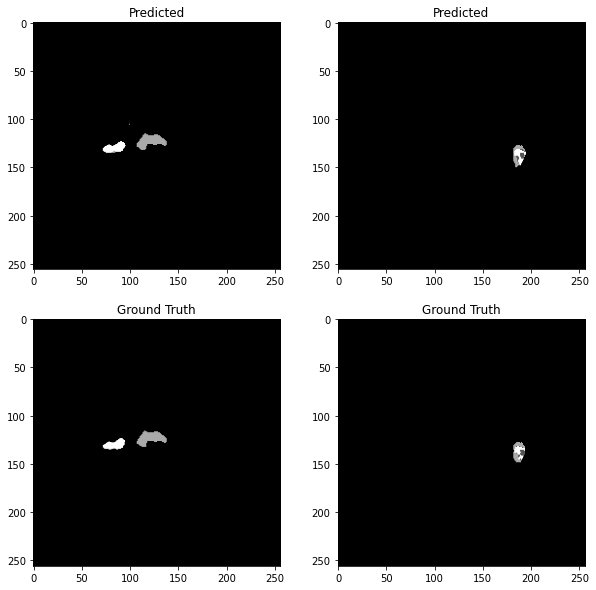

100%|██████████| 1022/1022 [08:46<00:00,  1.94it/s]


Average Validation Loss: 0.004765524050273701

Average Validation DSC: [0.99945854 0.92169523 0.93740316 0.88543211]
Average Validation ASSD: [ 0.07075844 10.49925482  7.2381318   7.41957153]
Epoch 24/50
-------------------------


  0%|          | 0/4086 [00:00<?, ?it/s]

Training Prediction Visualization:


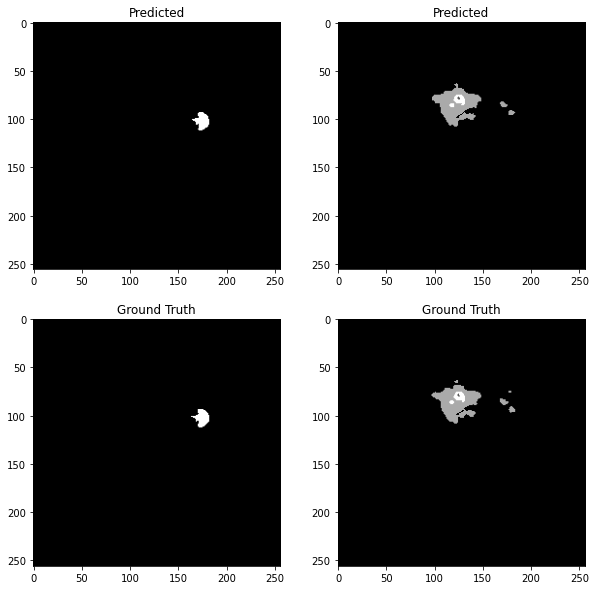

100%|██████████| 4086/4086 [52:48<00:00,  1.29it/s]



Average Training Loss: 0.0029364841136802398

Average Training DSC: [0.99958381 0.93334887 0.96073565 0.913824  ]
Average Training ASSD: [0.05092838 7.53143578 1.94795018 6.73268399]


  0%|          | 0/1022 [00:00<?, ?it/s]

Validation Prediction Visualization:


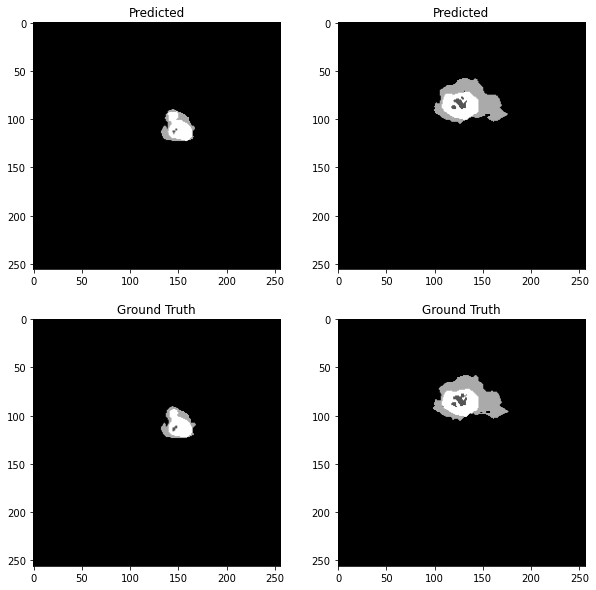

 33%|███▎      | 335/1022 [02:52<05:48,  1.97it/s]

In [ ]:
model = train_model(num_epochs = 50)